Filename:new_dataset_1.txt
Enter number of clusters:3
Enter sigma:0.73
7
Enter centroids? (Y or N) n
Actual iterations:9


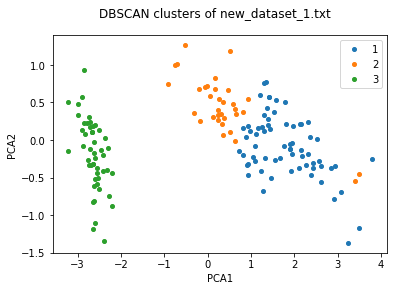

      Jaccard Coefficient:  0.6294979079497908
               Rand Index:  0.8425777777777778


In [62]:
import sys
import os
import random
import math 
import numpy as np
import pandas as pd
from math import sqrt
import matplotlib.pyplot as plt
from numpy import linalg as LA


def similarity_matrix(data, sigma):
    N = data.shape[0]
    matrix = np.zeros((N, N))
    for i in range(N):
        for j in range(N):
            norm = np.linalg.norm(data[i] - data[j])
            matrix[i][j] = np.exp(-norm**2 / (sigma * sigma))
    return matrix

file_name =input("Filename:")
# file_name = "cho.txt"
# file_name = "iyer.txt"
# file_name = "new_dataset_1.txt"
# file_name = "new_dataset_2.txt"
cluster_size = int(input("Enter number of clusters:"))
sigma = float(input("Enter sigma:"))

data = np.loadtxt(file_name, delimiter="\t",dtype='str')
data = np.asarray(data).astype(np.float)
ground_truth = data[:, 1]

data = np.delete(data,[0,1],axis=1)

W = similarity_matrix(data, sigma)
w = np.sum(W, axis=0)
D = np.diag(w)
L = D-W

eigval, eigvec = np.linalg.eig(L)
eigval = eigval.real
eigvec = eigvec.real
# print(sorted(eigval))
eigen_gap = np.argmax(np.diff(eigval))
# print(eigval)
print(eigen_gap)
X = [eigvec[:, i] for i in np.argsort(eigval)[0:eigen_gap+1]]
X = np.vstack(X).T
# print(X)


################# K-means ################################################
def random_centroids():
    random_k_indices= random.sample(range(1, len(features)), k)
    for i in range(len(random_k_indices)):
        centroids.append(features[random_k_indices[i]])
def cluster_Assignment(feature):
    min_dist=sys.maxsize
    closest_centroid=0
    for i in range(len(centroids)):
        dist=0
        for feature_index in range(len(feature)):
            dist+=(feature[feature_index]-centroids[i][feature_index])**2
        dist=math.sqrt(dist)
        if min_dist > dist:
            min_dist=dist
            closest_centroid=i
    return closest_centroid
def new_cluster_centroids(clus):
        new_clus_total=[]
        for each_point in clus:
            if len(new_clus_total):
                new_clus_total= [sum(n) for n in zip(*[features[each_point],new_clus_total])]
            else:
                new_clus_total=features[each_point]
        return np.divide(new_clus_total,len(clus))
    
features=X
k=cluster_size
centroids=[]
cent = input("Enter centroids? (Y or N) ")
if cent.lower() == 'n':
    random_centroids()
else:
    for cent in range(k):
        centroid_index=input("Enter index of centroid "+str(cent+1)+"-")
        centroids.append(features[int(centroid_index)])
# itr=int(input("Enter maximum iterations:"))
itr=100
# print(centroids)

for iteration in range(itr):
    new_centroids=[]
    clusters=[[] for _ in range(len(centroids))]
    for i in range(len(features)):
        clusters[cluster_Assignment(features[i])].append(i)
    for clus in clusters:
        if len(clus)>0:
            new_centroids.append(new_cluster_centroids(clus))
    if np.array_equal(centroids,new_centroids):
        print("Actual iterations:"+str(iteration))
        break
    centroids=new_centroids
test_clusters=[]
for i in range(len(features)):
    test_clusters.append(cluster_Assignment(features[i])+1)

################# PCA Visualization ################################################
data = np.loadtxt(file_name, delimiter="\t",dtype='str')
features_count = len(data[0])-1

data = np.asmatrix(data)
features = np.delete(data,[0,1],1)
features = features.astype(np.float)
labels = data[:, features_count]

mean_features = np.mean(features, axis=0)
adjusted_data = features - mean_features
covariance_matrix = np.cov(adjusted_data.T)

w, v = LA.eig(covariance_matrix)

w = w.argsort()[::-1][:2]
v = v[:,w]

principal_components = adjusted_data * v
principal_components = np.asarray(principal_components)

labels = test_clusters
df = pd.DataFrame(dict(xAxis=principal_components[:,0], yAxis=principal_components[:,1], label=labels))
diesase_groups = df.groupby('label')
    
fig, ax = plt.subplots()
fig.suptitle('DBSCAN clusters of ' + file_name)
for disease, diesase_group in diesase_groups:
    ax.plot(diesase_group.xAxis, diesase_group.yAxis, marker='o', linestyle='', ms=4, label=disease)

plt.xlabel('PCA1')
plt.ylabel('PCA2')
ax.legend()
plt.savefig('PCA_' + os.path.splitext(os.path.basename(file_name))[0] + ".png", dpi = 400)
plt.show()

################# Analysis ################################################
def get_incidence_matrix(labels):
    incidence_matrix = np.zeros((len(labels),len(labels)))
    for i in range(len(labels)):
        for j in range(len(labels)):
            incidence_matrix[i][j] = 1 if labels[i] == labels[j] else 0
    return incidence_matrix

def get_data_count(G, A):
    m11 = m00 = m10 = m01 = 0.0
    for i in range(len(G)):
        for j in range(len(G)):
            if G[i][j] == 1 and A[i][j] == 1:
                m11 += 1
            elif G[i][j] == 0 and A[i][j] == 0:
                m00 += 1
            elif G[i][j] == 0 and A[i][j] == 1:
                m10 += 1
            elif G[i][j] == 1 and A[i][j] == 0:
                m01 += 1
                
    return m11, m00, m10, m01

def jaccard(m11,m10,m01):
    return m11/(m11 + m10 + m01)

def rand(m00,m11,m10,m01):
    return (m00 + m11)/(m00 + m11 + m10 + m01)

# print(ground_truth)
# print(test_clusters)
ground_truth_matrix = get_incidence_matrix(ground_truth)
# print(ground_truth_matrix)
actual_cluster_matrix = get_incidence_matrix(test_clusters)
# print(tes)

m11,m00,m10,m01 = get_data_count(ground_truth_matrix, actual_cluster_matrix)
print('      Jaccard Coefficient: ', jaccard(m11,m10,m01))
print('               Rand Index: ', rand(m00,m11,m10,m01))